## DS 410 Final Project

Importing libraries, Creating Spark Session, and Reading in the Dataset

In [1]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.sql.functions import lower
from pyspark.sql.types import StructField, StructType, StringType, LongType, IntegerType, FloatType
from pyspark.sql.functions import col, column
from pyspark.sql.functions import expr
from pyspark.sql.functions import split
from pyspark.sql import Row
import xgboost
from xgboost.spark import SparkXGBClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import sparknlp
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType, ArrayType
from nltk.stem.porter import PorterStemmer
import nltk
nltk.download('punkt', quiet=True)
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.functions import vector_to_array
import seaborn as sns
from pyspark.mllib.evaluation import MulticlassMetrics
import numpy as np
from sklearn.metrics import roc_curve, average_precision_score, f1_score, accuracy_score
import random
from pyspark.sql.functions import concat_ws, array_join
from pyspark.sql.functions import col, when, lower, split, array_remove, regexp_replace
from pyspark.ml.feature import StopWordsRemover
import matplotlib.pyplot as plt

/storage/home/lfm5648/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/storage/home/lfm5648/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
ss=SparkSession.builder.master("local").appName("Final_Project").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/04 20:06:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
ss.sparkContext.setCheckpointDir("~/scratch")

In [4]:
schema = StructType([StructField("Sentiment", IntegerType(), nullable = False), \
                     StructField("Title", StringType(), nullable = False), \
                     StructField("Text", StringType(), nullable = False)
                    ])

In [5]:
reviews1 = ss.read.csv("Amazon_reviews_sample.csv", schema = schema, header = True, inferSchema = False)

In [6]:
reviews = reviews1.na.drop()

In [7]:
reviews.count()

399974

In [8]:
reviews.printSchema()

root
 |-- Sentiment: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Text: string (nullable = true)



In [9]:
reviews.show(5)

+---------+--------------------+--------------------+
|Sentiment|               Title|                Text|
+---------+--------------------+--------------------+
|        1|Sorry I wasted my...|Neil Gaiman wrote...|
|        1|Loved the prose, ...|Rabbit was not a ...|
|        2|         FASCINATING|Am a Jack Higgins...|
|        1|Little Annie Fann...|This was very, ve...|
|        2|     pressing matter|I have owned Rowe...|
+---------+--------------------+--------------------+
only showing top 5 rows


## EDA

## Distribution of Review Sentiment

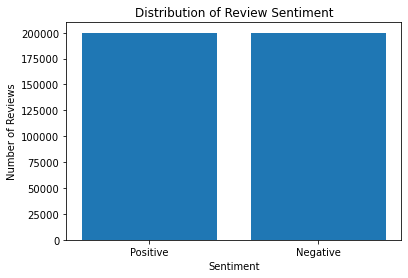

In [11]:
reviews_label = reviews.withColumn("Labeled_Sentiment", when(reviews["Sentiment"] == 2, "Positive").when(reviews["Sentiment"] == 1, "Negative"))
sentiment_counts = reviews_label.groupBy("Labeled_Sentiment").count()
pandas_sentiment=sentiment_counts.toPandas()
plt.bar(pandas_sentiment["Labeled_Sentiment"],pandas_sentiment["count"])
plt.title("Distribution of Review Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

Removing special characters

In [13]:
reviews_special_title = reviews_label.withColumn("Title", regexp_replace(col("Title"), "[^a-zA-Z0-9\\s]", ""))
reviews_only_text = reviews_special_title.withColumn("Text", regexp_replace(col("Text"), "[^a-zA-Z0-9\\s]", ""))

Making all words lowercase and splitting by space

In [14]:
reviews_split_title = reviews_only_text.withColumn("Title", split(lower(reviews_only_text["Title"]), " "))
reviews_split_title_text = reviews_split_title.withColumn("Text", split(lower(reviews_split_title["Text"]), " "))
reviews_split_title_text = (reviews_split_title_text.withColumn("Title", array_remove("Title", "")).withColumn("Text",  array_remove("Text", "")))

Removing stop words, making rdd of title of reviews and text of reviews for positive and negative sentiment

In [15]:
remover = StopWordsRemover(inputCols=["Title", "Text"], outputCols=["Title_No_Stop", "Text_No_Stop"])
reviews_no_stop_words = remover.transform(reviews_split_title_text)
reviews_combined = reviews_no_stop_words.withColumn("Combined", concat_ws(" ", "Title_No_Stop", "Text_No_Stop"))
reviews_pos = reviews_combined.filter(col("Labeled_Sentiment") == "Positive").select("Combined").rdd.flatMap(lambda row: row["Combined"].split())
reviews_neg = reviews_combined.filter(col("Labeled_Sentiment") == "Negative").select("Combined").rdd.flatMap(lambda row: row["Combined"].split())

Map words to key-value pairs ex. (word, 1)

In [16]:
reviews_pos_key_val = reviews_pos.map(lambda x: (x, 1))
reviews_neg_key_val = reviews_neg.map(lambda x: (x, 1))

Reduce key-value pairs by key (aggregate counts of words)

In [17]:
reviews_pos_key_val_reduced = reviews_pos_key_val.reduceByKey(lambda x, y: x + y)
reviews_neg_key_val_reduced = reviews_neg_key_val.reduceByKey(lambda x, y: x + y)

Sort aggregated counts of words in descending order

In [18]:
reviews_pos_key_val_sorted = reviews_pos_key_val_reduced.sortBy(lambda pair: pair[1], ascending=False)
reviews_neg_key_val_sorted = reviews_neg_key_val_reduced.sortBy(lambda pair: pair[1], ascending=False)

Get ten most frequent words for title of reviews and text of reviews

In [19]:
reviews_pos_key_val_sorted_top_ten = reviews_pos_key_val_sorted.take(10)
reviews_neg_key_val_sorted_top_ten  = reviews_neg_key_val_sorted.take(10)

## Bar graph of ten most frequent words in positive reviews

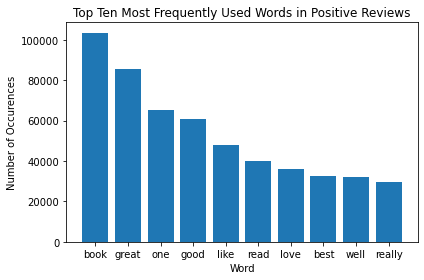

In [20]:
plt.bar([item[0] for item in reviews_pos_key_val_sorted_top_ten], [item[1] for item in reviews_pos_key_val_sorted_top_ten])
plt.xlabel("Word")
plt.ylabel("Number of Occurences")
plt.title("Top Ten Most Frequently Used Words in Positive Reviews")
plt.tight_layout()
plt.show()

## Bar graph of ten most frequent words in negative reviews

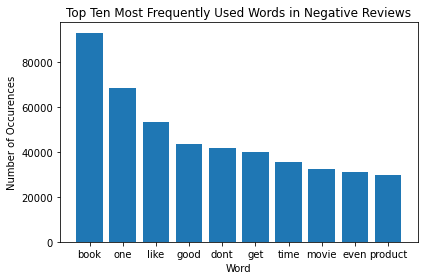

In [21]:
plt.bar([item[0] for item in reviews_neg_key_val_sorted_top_ten], [item[1] for item in reviews_neg_key_val_sorted_top_ten])
plt.xlabel("Word")
plt.ylabel("Number of Occurences")
plt.title("Top Ten Most Frequently Used Words in Negative Reviews")
plt.tight_layout()
plt.show()

# PreProcessing Data

Create a general stemming function

In [22]:
#General function to stem words
def stem_words(words):
    #if there are no words, return an empty list
    if words is None:
        return []
    
    #define a porter stemmer object
    stemmer = PorterStemmer()
    cleaned_stemmed = []
    
    #iterate through all words in review
    for word in words:
        #apply the stemmer object
        stemmed = stemmer.stem(word.lower())
        #add to list of stemmed words
        cleaned_stemmed.append(stemmed)
    
    #return stemmed list
    return cleaned_stemmed

#create spark user defined function for stem_words
stem_udf = udf(stem_words, ArrayType(StringType()))


Apply stemming function to text of reviews

In [23]:
reviews_stemmed = reviews_no_stop_words.withColumn(
    "Title_Stemmed",
    stem_udf(col("Title_No_Stop"))
).withColumn(
    "Text_Stemmed",
    stem_udf(col("Text_No_Stop"))
)

Preparing Data for Train/Validation/Test Split

In [24]:
#Combined stemmed title and text of reviews into one column called text
#Create binary labels where zero is negative sentiment and one is positive sentiment
reviews_for_transformers = reviews_stemmed.withColumn(
    "text",
    concat_ws(" ", 
              array_join(col("Title_Stemmed"), " "),
              array_join(col("Text_Stemmed"), " "))
).withColumn(
    "label",  # Binary label: 0=Negative, 1=Positive
    when(col("Sentiment") == 2, 1).otherwise(0)
).select("text", "label", "Sentiment", "Labeled_Sentiment")

Create Train/Validation/Test Split with a 60/20/20 Split

In [25]:
#Split data into train/validation/test set with 60/20/20 split, set random seed for reproduciblity
train_data, valid_data, test_data = reviews_for_transformers.randomSplit([0.6, 0.2, 0.2], seed=42)

#Cache the three data sets
train_data.cache()
valid_data.cache()
test_data.cache()

#Count the records to force computation and caching
train_count = train_data.count()
valid_count = valid_data.count()
test_count = test_data.count()

# print("Total Number of Reviews in Training Set: ", train_count)
# print("Total Number of Reviews in Validation Set: ", valid_count)
# print("Total Number of Reviews in Test Set: ", test_count)

Save PreProcessed Data to be Accessed later

In [26]:
#Define output path to save preprocessed data to
OUTPUT_PATH = "preprocessed_data_cluster"

#Save preprocessed tranining/validation/test data, overwritting what was there before (avoid overwriting errors)
train_data.write.mode("overwrite").parquet(f"{OUTPUT_PATH}/train_transformer_ready")
valid_data.write.mode("overwrite").parquet(f"{OUTPUT_PATH}/valid_transformer_ready")
test_data.write.mode("overwrite").parquet(f"{OUTPUT_PATH}/test_transformer_ready")

#Unpersist in order to free up memory
train_data.unpersist()
valid_data.unpersist()
test_data.unpersist()

#The data can be loaded with
#train_df = spark.read.parquet("preprocessed_data_sample/train_transformer_ready")
#valid_df = ss.read.parquet("preprocessed_data_sample/valid_transformer_ready")
#test_df  = ss.read.parquet("preprocessed_data_sample/test_transformer_ready")

DataFrame[text: string, label: int, Sentiment: int, Labeled_Sentiment: string]

# Model Building

Data PreProcessing for Model Building

In [27]:
#read in datasets from saved folder
train_df = ss.read.parquet("preprocessed_data_cluster/train_transformer_ready")
valid_df = ss.read.parquet("preprocessed_data_cluster/valid_transformer_ready")
test_df  = ss.read.parquet("preprocessed_data_cluster/test_transformer_ready")
#cast the labels into doubles, which is necessary for later models
for name in ("train_df","valid_df","test_df"):
    locals()[name] = locals()[name].withColumn("label", col("label").cast("double"))
#create tokenizer
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
#create hashing object to transform tokenized text into 50,000 term frequency vector
tf  = HashingTF(inputCol="tokens", outputCol="rawFeatures", numFeatures=50_000)
#create inverse document frequency transformer
idf = IDF(inputCol="rawFeatures", outputCol="features")
#create pipeline of data processing with review text being tokenized, transformed into term frequncy vector, then TF-IDF features, fit the preprocessing training data
featurizer = Pipeline(stages=[tokenizer, tf, idf]).fit(train_df)
#transform the traning/validation/test data, repartitioning the resulting dataframe and saving it in memory
train_f = featurizer.transform(train_df).select("features", "label").cache()
valid_f = featurizer.transform(valid_df).select("features", "label").cache()
test_f  = featurizer.transform(test_df).select("features", "label").cache()

Creating a general model training and evaluation function

In [28]:
#General model training function
def evaluate_model(model):
    #fit model on training data
    model = model.fit(train_f)
    #predict label on validation data
    valid_pred = model.transform(valid_f)
    #create evaluators for AUC-PR, AUC-ROC, F1, and Accuracy
    e_aucpr = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderPR")
    e_auc   = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
    e_f1    = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    e_acc   = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    #Evaluate metrics on validation data set
    print("Validation AUC-PR:", e_aucpr.evaluate(valid_pred))
    print("Validation AUC-ROC:", e_auc.evaluate(valid_pred))
    print("Validation F1:", e_f1.evaluate(valid_pred))
    print("Validation Acc:", e_acc.evaluate(valid_pred))
    #get raw decision score from model
    valid_scores = valid_pred.withColumn("raw_score", vector_to_array("rawPrediction")[0])
    #convert to pandas data frame
    pdf = valid_scores.select("label", "raw_score").toPandas()
    #get roc metrics
    fpr, tpr, _ = roc_curve(pdf["label"], pdf["raw_score"])
    #create ROC plot
    plt.figure(figsize=(7, 6))
    plt.plot(tpr, fpr, linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("Validation ROC Curve")
    plt.grid(True)
    plt.show()
    #convert prediction to rdd in tuple form as (prediction, actual label)
    preds_and_labels = valid_pred.select(['prediction', 'label']).rdd.map(tuple)
    #create multiclass metrics object
    metrics = MulticlassMetrics(preds_and_labels)
    #compute confusion matrix
    conf_matrix = metrics.confusionMatrix().toArray()
    #get labels of 0/1 from predictions
    labels = sorted(valid_pred.select('label').distinct().rdd.flatMap(lambda x: x).collect())
    #create data frame of confusion matrix
    df_cm = pd.DataFrame(conf_matrix, index=labels, columns=labels)
    #create heat map confusion matrix plot
    plt.figure(figsize=(8,6))
    sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Validation Confusion Matrix')
    plt.show()

# SVM

25/12/04 20:26:32 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/12/04 20:26:53 WARN DAGScheduler: Broadcasting large task binary with size 1242.7 KiB


Validation AUC-PR: 0.914384146632314


25/12/04 20:26:59 WARN DAGScheduler: Broadcasting large task binary with size 1242.7 KiB


Validation AUC-ROC: 0.9207411113729427


25/12/04 20:27:00 WARN DAGScheduler: Broadcasting large task binary with size 1243.4 KiB


Validation F1: 0.8514529402271405


25/12/04 20:27:00 WARN DAGScheduler: Broadcasting large task binary with size 1243.4 KiB


Validation Acc: 0.851465012930277


25/12/04 20:27:01 WARN DAGScheduler: Broadcasting large task binary with size 1235.0 KiB


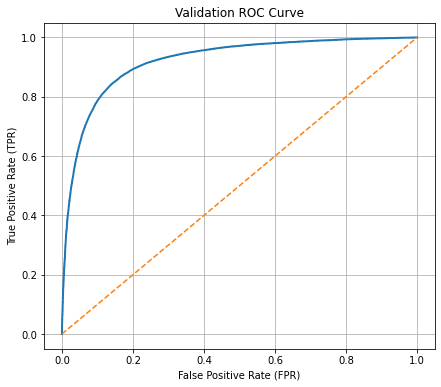

/storage/home/lfm5648/.local/lib/python3.9/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
25/12/04 20:27:02 WARN DAGScheduler: Broadcasting large task binary with size 1241.7 KiB
25/12/04 20:27:02 WARN DAGScheduler: Broadcasting large task binary with size 1255.4 KiB


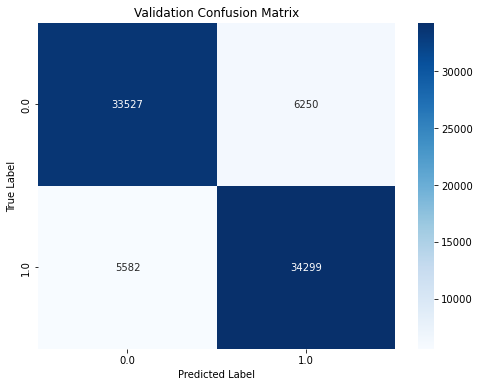

In [29]:
#define Linear SVC model
svm = LinearSVC(featuresCol="features", labelCol="label", maxIter=100, regParam=0.1)
#call evaluate_model function
evaluate_model(svm)

# Decision Tree

25/12/04 20:27:04 WARN DAGScheduler: Broadcasting large task binary with size 1340.2 KiB
25/12/04 20:27:40 WARN DAGScheduler: Broadcasting large task binary with size 1974.8 KiB
25/12/04 20:27:42 WARN MemoryStore: Not enough space to cache rdd_503_0 in memory! (computed 273.9 MiB so far)
25/12/04 20:27:42 WARN BlockManager: Persisting block rdd_503_0 to disk instead.
25/12/04 20:32:00 WARN MemoryStore: Not enough space to cache rdd_503_0 in memory! (computed 419.8 MiB so far)
25/12/04 20:33:22 WARN DAGScheduler: Broadcasting large task binary with size 1975.8 KiB
25/12/04 20:33:23 WARN MemoryStore: Not enough space to cache rdd_503_0 in memory! (computed 419.8 MiB so far)
25/12/04 20:34:46 WARN DAGScheduler: Broadcasting large task binary with size 1976.5 KiB
25/12/04 20:34:47 WARN MemoryStore: Not enough space to cache rdd_503_0 in memory! (computed 419.8 MiB so far)
25/12/04 20:36:12 WARN DAGScheduler: Broadcasting large task binary with size 1977.2 KiB
25/12/04 20:36:12 WARN MemoryS

Validation AUC-PR: 0.4695017025349364
Validation AUC-ROC: 0.5001512279911131
Validation F1: 0.719089586977016
Validation Acc: 0.7232293052800723


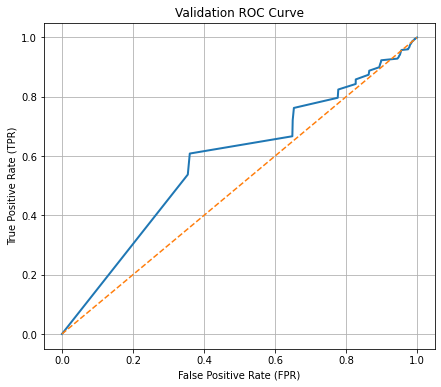

/storage/home/lfm5648/.local/lib/python3.9/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


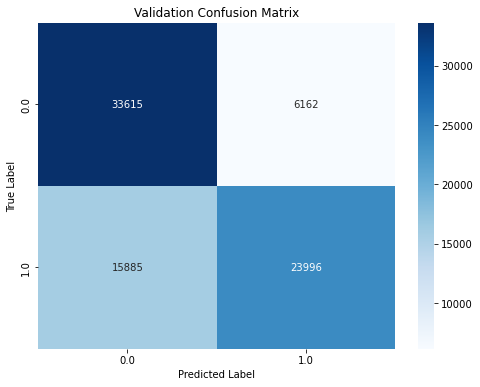

In [30]:
#define decision tree
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=10)
#call evaluate_model function
evaluate_model(dt)

# Random Forest

25/12/04 20:47:25 WARN DAGScheduler: Broadcasting large task binary with size 1340.3 KiB
25/12/04 20:48:01 WARN DAGScheduler: Broadcasting large task binary with size 2020.8 KiB
25/12/04 20:48:02 WARN MemoryStore: Not enough space to cache rdd_655_0 in memory! (computed 274.2 MiB so far)
25/12/04 20:48:02 WARN BlockManager: Persisting block rdd_655_0 to disk instead.
25/12/04 20:52:07 WARN MemoryStore: Not enough space to cache rdd_655_0 in memory! (computed 420.3 MiB so far)
25/12/04 20:53:14 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/12/04 20:53:15 WARN MemoryStore: Not enough space to cache rdd_655_0 in memory! (computed 420.3 MiB so far)
25/12/04 20:54:24 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/12/04 20:54:24 WARN MemoryStore: Not enough space to cache rdd_655_0 in memory! (computed 420.3 MiB so far)
25/12/04 20:55:33 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/12/04 20:55:34 WARN MemoryStore: Not

Validation AUC-PR: 0.8456799325769067


25/12/04 20:57:54 WARN DAGScheduler: Broadcasting large task binary with size 1088.9 KiB


Validation AUC-ROC: 0.8508720793456738


25/12/04 20:57:56 WARN DAGScheduler: Broadcasting large task binary with size 1101.3 KiB
25/12/04 20:57:57 WARN DAGScheduler: Broadcasting large task binary with size 1101.3 KiB


Validation F1: 0.7715339105679149


25/12/04 20:57:59 WARN DAGScheduler: Broadcasting large task binary with size 1081.1 KiB


Validation Acc: 0.7719249792864495


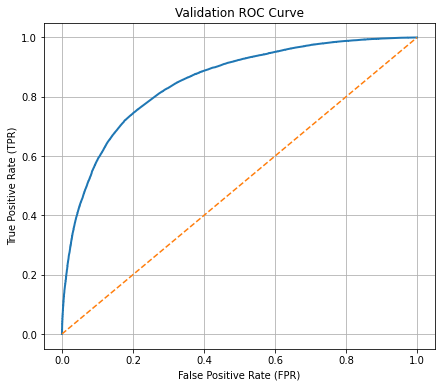

/storage/home/lfm5648/.local/lib/python3.9/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
25/12/04 20:58:00 WARN DAGScheduler: Broadcasting large task binary with size 1087.9 KiB
25/12/04 20:58:02 WARN DAGScheduler: Broadcasting large task binary with size 1101.7 KiB


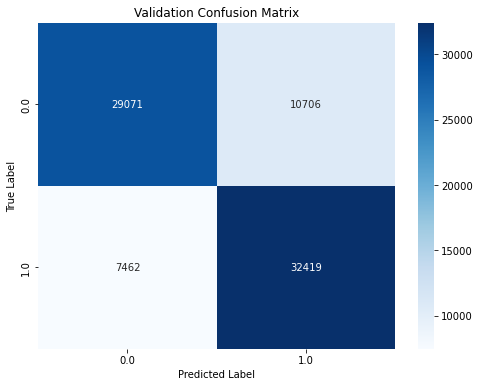

In [31]:
#define random forest model
rf = RandomForestClassifier(
    labelCol="label",
    featuresCol="features",
    numTrees=50,        
    maxDepth=5,        
    featureSubsetStrategy="auto",
)
#call evalaute_model function
evaluate_model(rf)

# Naive Bayes

25/12/04 20:58:05 WARN DAGScheduler: Broadcasting large task binary with size 1630.0 KiB


Validation AUC-PR: 0.5403812553298346


25/12/04 20:58:07 WARN DAGScheduler: Broadcasting large task binary with size 1630.0 KiB


Validation AUC-ROC: 0.5380361633430407


25/12/04 20:58:09 WARN DAGScheduler: Broadcasting large task binary with size 1642.5 KiB


Validation F1: 0.7975135945768864


25/12/04 20:58:09 WARN DAGScheduler: Broadcasting large task binary with size 1642.5 KiB


Validation Acc: 0.797521906148786


25/12/04 20:58:09 WARN DAGScheduler: Broadcasting large task binary with size 1622.3 KiB


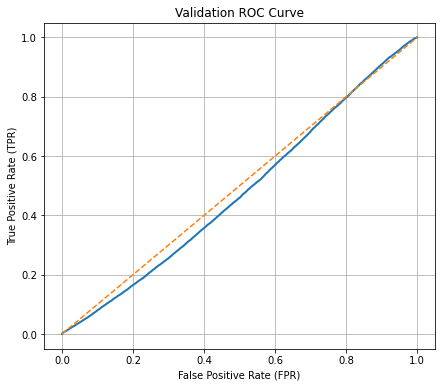

/storage/home/lfm5648/.local/lib/python3.9/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
25/12/04 20:58:10 WARN DAGScheduler: Broadcasting large task binary with size 1629.1 KiB
25/12/04 20:58:11 WARN DAGScheduler: Broadcasting large task binary with size 1643.4 KiB


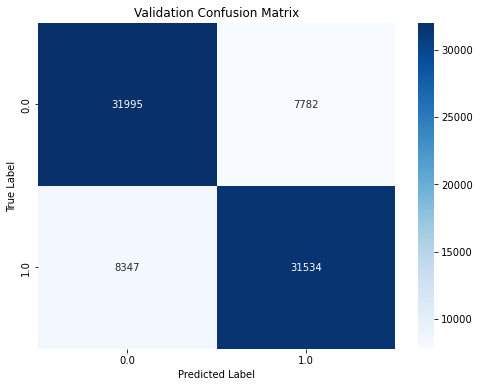

In [32]:
#define naive bayes model
nb = NaiveBayes(
    labelCol="label",
    featuresCol="features",
    modelType="multinomial",
    smoothing=1.0
)

#call evaluate_model function
evaluate_model(nb)

# Hyperparameter Tuning on Linear SVC

25/12/04 20:58:28 WARN DAGScheduler: Broadcasting large task binary with size 1244.8 KiB
25/12/04 20:59:06 WARN DAGScheduler: Broadcasting large task binary with size 1245.8 KiB
25/12/04 20:59:23 WARN DAGScheduler: Broadcasting large task binary with size 1244.9 KiB
25/12/04 20:59:33 WARN DAGScheduler: Broadcasting large task binary with size 1244.5 KiB
25/12/04 20:59:39 WARN DAGScheduler: Broadcasting large task binary with size 1244.3 KiB
25/12/04 20:59:55 WARN DAGScheduler: Broadcasting large task binary with size 1244.8 KiB
25/12/04 21:00:24 WARN DAGScheduler: Broadcasting large task binary with size 1245.5 KiB
25/12/04 21:00:42 WARN DAGScheduler: Broadcasting large task binary with size 1244.9 KiB
25/12/04 21:01:10 WARN DAGScheduler: Broadcasting large task binary with size 1245.4 KiB
25/12/04 21:01:23 WARN DAGScheduler: Broadcasting large task binary with size 1244.7 KiB
25/12/04 21:01:52 WARN DAGScheduler: Broadcasting large task binary with size 1245.4 KiB
25/12/04 21:02:09 WAR

Best hyperparameters:
regParam: 0.009444574254983556
maxIter: 90
tol: 0.0006960678239135184
fitIntercept: False
standardization: False


25/12/04 21:12:15 WARN DAGScheduler: Broadcasting large task binary with size 1244.6 KiB


Best Model Validation AUC-PR: 0.939299832781154
Best Model Validation AUC-ROC:  0.94144390469962


25/12/04 21:12:16 WARN DAGScheduler: Broadcasting large task binary with size 1245.1 KiB


Best Model Validation F1: 0.8728755624982358
Best Model Validation Acc: 0.8728815687062191


25/12/04 21:12:16 WARN DAGScheduler: Broadcasting large task binary with size 1245.1 KiB
25/12/04 21:12:16 WARN DAGScheduler: Broadcasting large task binary with size 1236.5 KiB


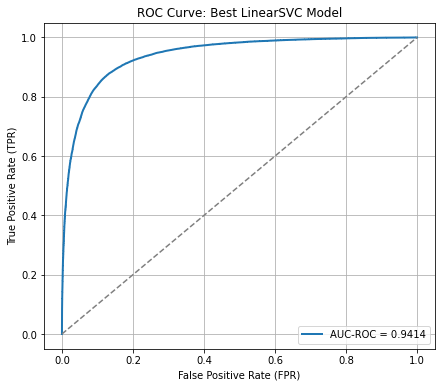

/storage/home/lfm5648/.local/lib/python3.9/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
25/12/04 21:12:17 WARN DAGScheduler: Broadcasting large task binary with size 1243.4 KiB
25/12/04 21:12:18 WARN DAGScheduler: Broadcasting large task binary with size 1257.1 KiB


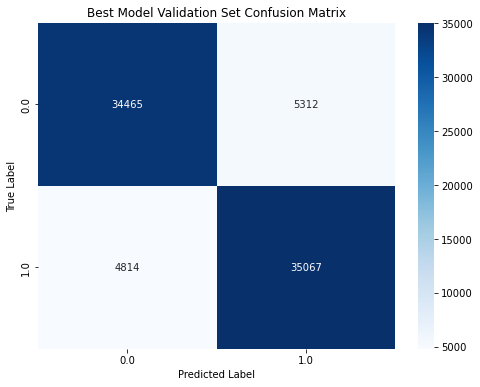

In [34]:
#define linear SVC model
svm_base = LinearSVC(featuresCol="features", labelCol="label")
#define want to train 50 randomly selected model
n_samples = 50
#set random seeds
np.random.seed(42)
random.seed(42)

param_grid = []
#loop through n_samples to randomly select param_grid for each iteration
for _ in range(n_samples):
    #defined parameters grid to sample from
    param_grid.append({
        "regParam": 10**np.random.uniform(-4, 0),
        "maxIter": np.random.randint(1, 21) * 10,
        "tol": 10**np.random.uniform(-6, -2),
        "fitIntercept": bool(np.random.choice([True, False])),
        "standardization": bool(np.random.choice([True, False])),
    })
    
#define AUC-ROC evaluator as going to use AUC-ROC to choose the best hyperparameter tuned model
evaluator_auc = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

results = []
#loop over set of randomly selected parameter settings
for params in param_grid:
    #get copy of svm_base model
    svm = svm_base.copy()
    #set paramters to linear SVC model defined above
    svm = svm.setParams(**params)
    #fit model on training set
    model = svm.fit(train_f)
    #predict on validation set
    pred = model.transform(valid_f)
    #compute AUC-ROC
    auc = evaluator_auc.evaluate(pred)
    #append parameters and AUC-ROC score to results
    results.append({
        "params": params,
        "AUC_ROC": auc
    })

#get best result by AUC-ROC
best_result = max(results, key=lambda x: x["AUC_ROC"])
#output best hyperparameters
print("Best hyperparameters:")
for name, value in best_result["params"].items():
    print(f"{name}: {value}")
#get paramters of best model
best_params = best_result["params"]
#get copy of base svc model
svm = svm_base.copy()
#set best hyperparamters
svm = svm.setParams(**best_params)
#fit best model on training set
best_model = svm.fit(train_f)
#transform validation set with best model
valid_pred = best_model.transform(valid_f)
#create evaluator objects
e_aucpr = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderPR")
e_f1    = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
e_acc   = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
#Evaluate metrics on validation data set
print("Best Model Validation AUC-PR:", e_aucpr.evaluate(valid_pred))
print("Best Model Validation AUC-ROC: ", best_result['AUC_ROC'])
print("Best Model Validation F1:", e_f1.evaluate(valid_pred))
print("Best Model Validation Acc:", e_acc.evaluate(valid_pred))
valid_pred_scores = valid_pred.withColumn("raw_score", vector_to_array("rawPrediction")[0])
#convert predictions to pandas
pdf_valid = valid_pred_scores.select("label", "raw_score").toPandas()
#compute ROC curve
fpr, tpr, _ = roc_curve(pdf_valid["label"], pdf_valid["raw_score"])
#create ROC curve
plt.figure(figsize=(7, 6))
plt.plot(tpr, fpr, linewidth=2, label=f"AUC-ROC = {best_result['AUC_ROC']:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve: Best LinearSVC Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#get prediction and acutal labels as tuple rdd in form (prediction, label)
preds_and_labels = valid_pred.select(['prediction', 'label']).rdd.map(tuple)
#create metrics object
metrics = MulticlassMetrics(preds_and_labels)
#create confusion matrix
conf_matrix = metrics.confusionMatrix().toArray()
#get valid labels
labels = sorted(valid_pred.select('label').distinct().rdd.flatMap(lambda x: x).collect())
#create pandas data frame of confusion matrix
df_cm = pd.DataFrame(conf_matrix, index=labels, columns=labels)
#create confusion matrix heat map
plt.figure(figsize=(8,6))
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Best Model Validation Set Confusion Matrix')
plt.show()

# Evaluation on Test Split

25/12/04 21:12:19 WARN DAGScheduler: Broadcasting large task binary with size 1244.6 KiB


Best Model Test AUC-PR: 0.9371898961702712


25/12/04 21:12:23 WARN DAGScheduler: Broadcasting large task binary with size 1244.6 KiB


Best Model Test AUC-ROC: 0.9406846418946565


25/12/04 21:12:24 WARN DAGScheduler: Broadcasting large task binary with size 1245.1 KiB


Best Model Test F1: 0.8720839070913065
Best Model Test Acc: 0.872097240111546


25/12/04 21:12:25 WARN DAGScheduler: Broadcasting large task binary with size 1245.1 KiB
25/12/04 21:12:25 WARN DAGScheduler: Broadcasting large task binary with size 1236.5 KiB
25/12/04 21:12:25 WARN DAGScheduler: Broadcasting large task binary with size 1244.6 KiB


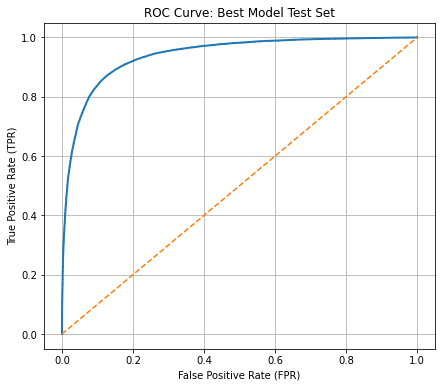

/storage/home/lfm5648/.local/lib/python3.9/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
25/12/04 21:12:27 WARN DAGScheduler: Broadcasting large task binary with size 1243.4 KiB
25/12/04 21:12:27 WARN DAGScheduler: Broadcasting large task binary with size 1257.1 KiB


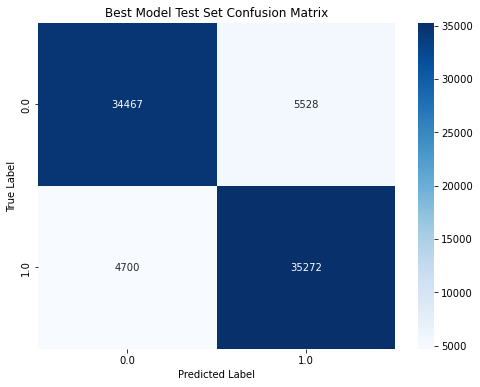

In [35]:
#use best model to predict on test set
test_pred = best_model.transform(test_f)
#create evaluator objects
e_aucpr = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderPR")
e_auc   = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
e_f1    = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
e_acc   = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
#Evaluate metrics on test data set
print("Best Model Test AUC-PR:", e_aucpr.evaluate(test_pred))
print("Best Model Test AUC-ROC:", e_auc.evaluate(test_pred))
print("Best Model Test F1:", e_f1.evaluate(test_pred))
print("Best Model Test Acc:", e_acc.evaluate(test_pred))
#get raw decision score from model
test_scores = test_pred.withColumn("raw_score", vector_to_array("rawPrediction")[0])
#convert to pandas data frame
pdf = test_scores.select("label", "raw_score").toPandas()
#get roc metrics
fpr, tpr, _ = roc_curve(pdf["label"], pdf["raw_score"])
#create ROC plot
plt.figure(figsize=(7, 6))
plt.plot(tpr, fpr, linewidth=2, label=f"AUC-ROC = {e_auc.evaluate(test_pred)}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve: Best Model Test Set")
plt.grid(True)
plt.show()

#get prediction and acutal labels as tuple rdd in form (prediction, label)
preds_and_labels = test_pred.select(['prediction', 'label']).rdd.map(tuple)
#create metrics object
metrics = MulticlassMetrics(preds_and_labels)
#create confusion matrix
conf_matrix = metrics.confusionMatrix().toArray()
#get valid labels
labels = sorted(valid_pred.select('label').distinct().rdd.flatMap(lambda x: x).collect())
#create pandas data frame of confusion matrix
df_cm = pd.DataFrame(conf_matrix, index=labels, columns=labels)
#create confusion matrix heat map
plt.figure(figsize=(8,6))
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Best Model Test Set Confusion Matrix')
plt.show()

In [36]:
ss.stop()